In [1]:
# Load all helper function
%run -i 'source.py'
data = pd.read_feather("../processing/train_with_feature.feather")

In [2]:
from datetime import datetime
data.loc[:, 'click_time'] = (data.loc[:, 'click_time'] - datetime(2017,11,8)).dt.total_seconds()
print(f"Percent download (target): {data.is_attributed.sum()/data.shape[0]*100}%")

Percent download (target): 0.24272401627499288%


### Create X and y data from whole dataset

In [3]:
X_cols = data.columns.to_list()  #Names of features
X_cols.remove('is_attributed')
X_cols.remove('attributed_time') #Need to recode attributed time eventually... for now just dropping it
y_cols = ['is_attributed']

#### Create inital dev/test split. (use at most 50% of data)
Only using the row indices here to save memory on the splits. Will call in the full data only during training

In [4]:
from sklearn.model_selection import train_test_split, cross_validate
X_dev, X_test= train_test_split(data.index, stratify = data['is_attributed'], train_size = 0.5, shuffle = True, random_state = 0)

In [5]:
#Check Stratified Split proportions
print(f"Proportion of positives in Dev: {data['is_attributed'].iloc[X_dev].sum()/X_dev.shape[0]}")

Proportion of positives in Dev: 0.0024272241659956807


#### Create Train/Val Split. This time using 10% of dev for train; still too much data

In [6]:
#Create Train/Val Split
X_train, X_val = train_test_split(X_dev, stratify = data.loc[X_dev, 'is_attributed'], train_size = 0.1, shuffle = True, random_state = 0 )

In [7]:
print(f"Proportion of positives in train: {data['is_attributed'].iloc[X_train].sum()/X_train.shape[0]}")

Proportion of positives in train: 0.002427160334658201


#### Create a smaller validation set from larger validation set if needed
Will eventually use this to adjust to using whole validation set as experiments progress

In [8]:
val_subsample = X_val

In [9]:
X_mini_val = data.loc[val_subsample, X_cols]
y_mini_val = data.loc[val_subsample, y_cols]

### Undersampling

In [12]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(replacement = False, random_state = 0)
X_train_subsample, y_train_subsample = rus.fit_resample(X_train.to_numpy().reshape(-1,1), data.loc[X_train, 'is_attributed'])

Get number of each label in the undersample set

In [13]:
#Get size of subsample
import numpy as np
np.unique(y_train_subsample, return_counts = True)

(array([0, 1], dtype=int8), array([7568, 7568]))

In [14]:
#Train small RandomForest on UnderSampled Data
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, plot_precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
rfc = RandomForestClassifier(n_estimators = 50, max_depth = 5, random_state=0)
rfc_model = rfc.fit(data.loc[X_train_subsample.reshape(-1,), X_cols], y_train_subsample)

y_pred_prob = rfc_model.predict_proba(data.loc[val_subsample, X_cols])[:,1]
fpr, tpr, thresholds = roc_curve(data.loc[val_subsample, y_cols], y_pred_prob, pos_label = 1)


### Baseline (Stratified)
Get training set from original data that is the same size as Undersampled set, but only stratifed

In [15]:
n_subsample = X_train_subsample.shape[0]
X_train_base = X_train[:n_subsample] #Get as many samples to train baseline as there were from the undersampling

rfc_base = RandomForestClassifier(n_estimators = 50, max_depth = 5, random_state=0)
rfc_model_base = rfc_base.fit(data.loc[X_train_base, X_cols], data.loc[X_train_base, 'is_attributed'])


### Ensemble Resampling

In [16]:
resampled_rf = BalancedRandomForestClassifier(random_state = 0, n_estimators = 50, max_depth = 5)
resampled_rf.fit(data.loc[X_train_base, X_cols], data.loc[X_train_base, 'is_attributed'])

BalancedRandomForestClassifier(max_depth=5, n_estimators=50, random_state=0)

### Create a SMOTE sample set

In [18]:
from imblearn.over_sampling import SMOTE
rus_1 = SMOTE(random_state = 0)
X_train_subsample_smote, y_train_subsample_smote = rus_1.fit_resample(X_train.to_numpy().reshape(-1,1), data.loc[X_train, 'is_attributed'])

In [22]:
rfc1 = RandomForestClassifier(n_estimators = 50, max_depth = 5, random_state=0)
rfc_model_smote = rfc1.fit(data.loc[X_train_subsample_smote.reshape(-1,), X_cols], y_train_subsample_smote)

#y_pred_prob_smote = rfc_model_smote.predict_proba(data.loc[val_subsample, X_cols])[:,1]
#fpr_smote, tpr_smote, thresholds_smote = roc_curve(data.loc[val_subsample, y_cols], y_pred_prob_smote, pos_label = 1)


In [23]:
print(X_cols)

['ip', 'app', 'device', 'os', 'channel', 'click_time', 'day_of_week', 'day', 'hour', 'minute', 'click_freq_by_ip', 'download_rate_by_ip', 'click_freq_by_app', 'download_rate_by_app', 'click_freq_by_device', 'download_rate_by_device', 'click_freq_by_os', 'download_rate_by_os', 'click_freq_by_channel', 'download_rate_by_channel', 'click_freq_by_hour', 'download_rate_by_hour', 'click_freq_by_app_channel', 'download_rate_by_app_channel', 'click_freq_by_ip_hour', 'download_rate_by_ip_hour', 'click_freq_by_ip_device_app', 'download_rate_by_ip_device_app', 'click_freq_by_ip_device_os', 'download_rate_by_ip_device_os', 'click_freq_by_ip_device_os_hour', 'download_rate_by_ip_device_os_hour', 'nunique_channel_per_ip', 'nunique_device_per_ip', 'nunique_app_per_ip', 'nunique_os_per_ip', 'nunique_channel_per_app']


### Plot PR curves for each sampling type

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curv

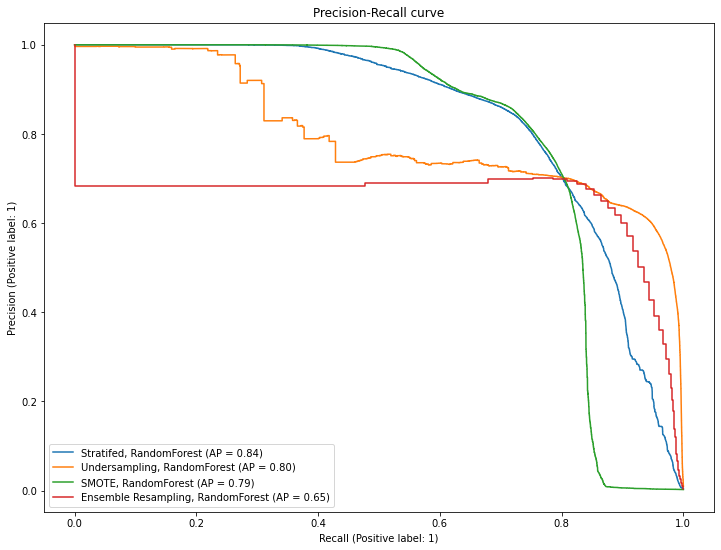

In [24]:
from matplotlib import pyplot as plt
plot_precision_recall_curve(rfc_model_base,  X_mini_val, y_mini_val, ax = plt.gca(),name = "Stratifed, RandomForest")
plot_precision_recall_curve(rfc_model, X_mini_val, y_mini_val, ax = plt.gca(),name = "Undersampling, RandomForest")
plot_precision_recall_curve(rfc_model_smote, X_mini_val, y_mini_val, ax = plt.gca(),name = "SMOTE, RandomForest")
plot_precision_recall_curve(resampled_rf,  X_mini_val, y_mini_val, ax = plt.gca(),name = "Ensemble Resampling, RandomForest")

plt.title('Precision-Recall curve')
plt.rcParams["figure.figsize"] = (12,9)


- The result shows that undersampling works best, while SMOTE also has a high precision when recall is around 0.6